In [1672]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stcs
from pandas import DataFrame
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

In [1673]:
PATH_CODED_IDS_TRAIN = "data/users/coded_ids_labels_train.csv"
PATH_CODED_IDS_TEST = "data/users/coded_ids_labels_test.csv"
PATH_FEATURES = "data/users_features/features.csv"
PATH_CODED = "data/users/coded_ids.csv"

In [1674]:
report_users = pd.read_csv(PATH_CODED_IDS_TEST)
coded_ids = pd.read_csv(PATH_CODED)
train_users = pd.read_csv(PATH_CODED_IDS_TRAIN)
features = pd.read_csv(PATH_FEATURES)
print("number of elements in train : " , len(train_users))

number of elements in train :  686


## Plot of spam/legit pie chart

118
568


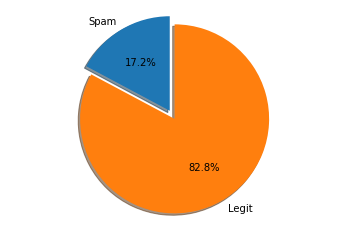

In [1675]:
spam_counter = 0
legit_counter = 0
train_len = len(train_users)
for i in train_users[:]['label']:
    if i == 1:
        spam_counter += 1
    else:
        legit_counter += 1
print(spam_counter)
print(legit_counter)

labels = 'Spam', 'Legit'
pie_sizes = [100 / train_len * spam_counter, 100 / train_len * legit_counter]
fig1, ax1 = plt.subplots()
ax1.pie(pie_sizes, explode=(0.1, 0), labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

## Data preprocessing

In [1676]:
#NaN clearing
# print(features.dtypes.to_string(max_rows=10000))
(value_nan, features_nan) = np.where(pd.isnull(features))
features_nan = list(dict.fromkeys(features_nan))

print("columns with NaN deleted : ", list(features.columns[features_nan]))

#Dropping of NaN containing columns
# features = features.drop(list(features.columns[features_nan]), axis=1)

#Dropping of Null containing columns
features = features.drop('spam_in_screen_name', axis=1)

#Object features clearing
features = features.select_dtypes(exclude=[object])
print('number of features : ', len(features.columns))
print('number of object type features : ', len(features.dtypes[features.dtypes == object]))



columns with NaN deleted :  ['spam_in_screen_name', 'time_zone', 'utc_offset']
number of features :  136
number of object type features :  0


## Joining tables and splitting train/test

In [1677]:
features_ids = pd.merge(features, coded_ids, on='user_id', how='right')
features = pd.merge(features_ids, train_users, on='coded_id')
report_features = pd.merge(features_ids, report_users, on='coded_id')

#Setting values type to float64
features = features.apply(pd.to_numeric).astype('float64')
# report_features = pd.merge(features_ids, report_users, on='coded_id')
#Removing user_id and coded_id
X = features.iloc[:, :-3]
ids_report = report_features['coded_id']
X_report = report_features.iloc[:, :-3]
y = features.loc[:, 'label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=40
)


X_train = X_train.fillna(X_train.mean())
y_train = y_train.fillna(y_train.mean())
X_test = X_test.fillna(X_test.mean())
y_test = y_test.fillna(y_test.mean())
X_report = X_report.fillna(X_report.mean())




(value_nan, features_nan) = np.where(pd.isnull(X_train))
features_nan = list(dict.fromkeys(X_train))
# print(features_nan)
# print("columns with NaN deleted : ", list(X_train.columns[features_nan]))


#Normalizing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.fit_transform(X_test.values)
X_report_scaled = scaler.fit_transform(X_report.values)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_report = pd.DataFrame(X_report_scaled, columns=X_report.columns)

# print(y_train.to_string(max_rows=150000))
# for j in X_train.isnull().values:
#     [print(i) for i in j if i == False]

# for j in X_train.isnull().values:
#     [print(i) for i in j if i == True]


# print(X_train.isnull().sum().to_string(max_rows=1500))

## Plot of the best features

d:\python\3.9.1\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[ 87 128 127 111  99  30   5  72  29 101  73  59  41  47  75 112  46  93
  42 107   3 118  22  78  95 130   8  58  84  11 116 132  86   2  96 104
  53  25  54   9  97  24 100 106   4  52  79   7 129  61  63  51  39  36
  88  74  40  13   1  15  81  89  65  21  66 134   6 103  62  55 133  83
  48  60  69  90  85 121  14  12 102   0  34 117  43 113  98 126  31 105
  27  49  17  16  23  26  35  37 109 108  82  77  38  50 122  19  20  80
  76  91 120 125  32 119  28  18 114 131  45 123  33 110 124  68 115  10
  64  44  94  67  92  70  57  56  71]
Index(['active_tweeting_frequency_per_day', 'adjusted_nb_of_uses_of_hashtag',
       'adjusted_nb_of_uses_of_mention', 'adjusted_nb_of_uses_of_sources',
       'adjusted_nb_of_uses_of_url', 'age', 'avg_intertweet_times_seconds',
       'content_duration_days', 'default_profile', 'default_profile_image',
       ...
       'temporal_bin_6', 'temporal_bin_7', 'time_since_newest_tweet_days',
       'time_since_newest_tweet_months', 'tweeting_frequency

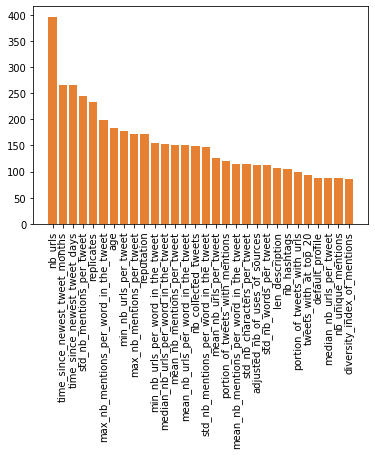

In [1678]:
kb = SelectKBest(score_func=f_regression, k=10)
kb.fit(X, y)
indices = np.argsort(-1*kb.scores_)

print(indices)
plt.figure()
plt.bar(X.columns[indices[:30]], kb.scores_[indices[range(30)]], color=(0.9,0.5,0.2), align='center')
plt.xticks(rotation=90)

print(X.columns)
print(kb.scores_[np.argsort(kb.scores_)])
print(indices)

## LinearSVC with all non object features

In [1679]:
linearSVC_full = LinearSVC()
linearSVC_full.fit(X_train, y_train)
score = linearSVC_full.score(X_train, y_train)
print("final train score : ", score)


y_pred = linearSVC_full.predict(X_test)

test_report = classification_report(y_test, y_pred)
print(test_report)

final train score :  1.0
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       107
         1.0       0.84      0.84      0.84        31

    accuracy                           0.93       138
   macro avg       0.90      0.90      0.90       138
weighted avg       0.93      0.93      0.93       138



d:\python\3.9.1\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## LinearSVC with top 5 non object features

In [1680]:
X_top_features = ['nb_urls', 'time_since_newest_tweet_months', 'time_since_newest_tweet_days', 'replicates', 'std_nb_mentions_per_tweet']
for feature in X_top_features:
    print("feature : {} | mean : {} | median : {} | variance: {} | min : {} | max : {}"
          .format(feature, stcs.mean(X_train[feature]), stcs.median(X_train[feature]), stcs.variance(X_train[feature]), X_train[feature].min(), X_train[feature].max()))

linearSVC = LinearSVC()
linearSVC.fit(X_train[X_top_features], y_train)
score = linearSVC.score(X_train[X_top_features], y_train)
print("\nfinal train score : ", score)


y_pred = linearSVC.predict(X_test[X_top_features])

test_report = classification_report(y_test, y_pred)
print(test_report)

feature : nb_urls | mean : 2.1302594218222487e-17 | median : -0.33270331302897704 | variance: 1.0018281535648996 | min : -1.0306499604090253 | max : 5.351729208118353
feature : time_since_newest_tweet_months | mean : -4.144343019614664e-17 | median : -0.3565792969056095 | variance: 1.0018281535648994 | min : -0.3632792953525244 | max : 7.723618830073798
feature : time_since_newest_tweet_days | mean : 7.717620135823825e-18 | median : -0.3565792969056094 | variance: 1.0018281535648992 | min : -0.36327929535252435 | max : 7.723618830073798
feature : replicates | mean : 2.9571020713206834e-17 | median : -0.39768607930312666 | variance: 1.0018281535648994 | min : -0.6059115407874331 | max : 5.57678293097736
feature : std_nb_mentions_per_tweet | mean : -2.745657916797039e-17 | median : -0.04235500724633792 | variance: 1.0018281535648994 | min : -1.674182054031672 | max : 3.971999487149537

final train score :  0.9598540145985401
              precision    recall  f1-score   support

        

d:\python\3.9.1\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## SVC (RBF)

In [1681]:
SVC_RBF = svm.SVC(kernel='rbf', C=1)
SVC_RBF.fit(X_train, y_train)
score = SVC_RBF.score(X_train, y_train)
y_pred = SVC_RBF.predict(X_test)

test_report = classification_report(y_test, y_pred)
print(test_report)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       107
         1.0       0.94      0.94      0.94        31

    accuracy                           0.97       138
   macro avg       0.96      0.96      0.96       138
weighted avg       0.97      0.97      0.97       138



## report prediction

In [1682]:
report_pred = SVC_RBF.predict(X_report)

report_df = DataFrame({'coded_id': ids_report
                      ,'label': map(int, report_pred.tolist())})

print(report_df)
# report_df.to_csv("coded_ids_labels_test.csv", index=False, index_label=['coded_id', 'label'])

    coded_id  label
0          5      0
1         26      1
2         37      1
3         40      0
4         52      1
..       ...    ...
76       729      0
77       745      0
78       746      0
79       757      0
80       762      0

[81 rows x 2 columns]
